In [1]:
%reload_ext autoreload
%autoreload 2

import time as tt
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 18})

from utils import get_track

## First, start by defining the paramters

In [2]:
# Flattened NFW halo
logM, Rs, q = 12.0, 25.0, 0.8
dirx, diry, dirz = 1.0, 1.0, 1.0

# Plummer Sattelite
logm, rs = 8.0, 2.0 

# Initial conditions
x0, y0, z0 = 100.0, 0.0, 0.0     # Position in kpc
vx0, vy0, vz0 = 0.0, 200.0, 0.0  # Velocity in km/s

# Integration time
time = 3.0 # Gyr
alpha = 1.05

params = (logM, Rs, q, dirx, diry, dirz, logm, rs, x0, y0, z0, vx0, vy0, vz0, time, alpha)

n_steps = 500 # Number of steps in the time integration
n_particles = 10000 # Number of particles in the stream

## (1) Spray Method

In [141]:
from models import generate_stream_spray

start = tt.time()
theta_stream, xv_stream = generate_stream_spray(params,  seed=111, n_steps=n_steps, n_particles=n_particles)
end = tt.time()
print(f"Time taken to generate stream using Spray: {end - start:.2f} seconds")
count, theta_bin, r_bin, w_bin = get_track(theta_stream, xv_stream[:, 0], xv_stream[:, 1])

/Users/davidchemaly/miniforge3/envs/Astro/lib/python3.10/site-packages/jax/_src/core.py:691: FutureWarning: unhashable type: <class 'jax._src.interpreters.partial_eval.DynamicJaxprTracer'>. Attempting to hash a tracer will lead to an error in a future JAX release.
  warnings.warn(
/Users/davidchemaly/miniforge3/envs/Astro/lib/python3.10/site-packages/jax/_src/core.py:691: FutureWarning: unhashable type: <class 'jax._src.interpreters.partial_eval.DynamicJaxprTracer'>. Attempting to hash a tracer will lead to an error in a future JAX release.
  warnings.warn(


Time taken to generate stream using Spray: 3.00 seconds


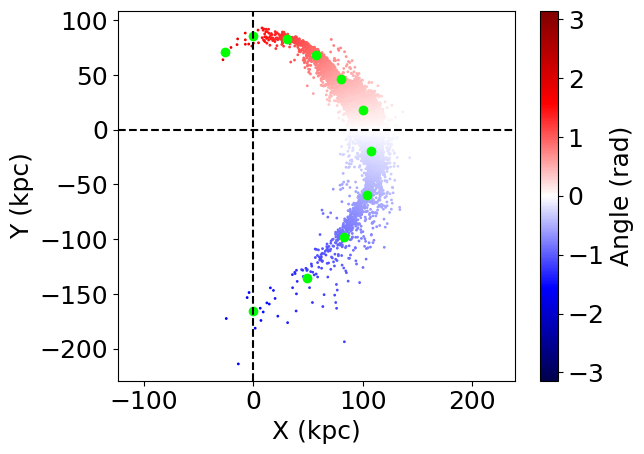

In [142]:
plt.scatter(xv_stream[:, 0], xv_stream[:, 1], c=theta_stream, s=1, cmap='seismic', vmin=-np.pi, vmax=np.pi)
plt.colorbar(label='Angle (rad)')
plt.scatter(r_bin*np.cos(theta_bin), r_bin*np.sin(theta_bin), c='lime')
plt.axvline(0, color='k', linestyle='--')
plt.axhline(0, color='k', linestyle='--')
plt.xlabel('X (kpc)')
plt.ylabel('Y (kpc)')
plt.axis('equal');

## (2) Streak Method

In [ ]:
from models import generate_stream_streak

start = tt.time()
theta_stream, xv_stream = generate_stream_streak(params,  seed=111, n_steps=n_steps, n_particles=n_particles)
end = tt.time()
print(f"Time taken to generate stream using Streak: {end - start:.2f} seconds")
count, theta_bin, r_bin, w_bin = get_track(theta_stream, xv_stream[:, 0], xv_stream[:, 1])

Time taken to generate stream using Spray: 0.17 seconds


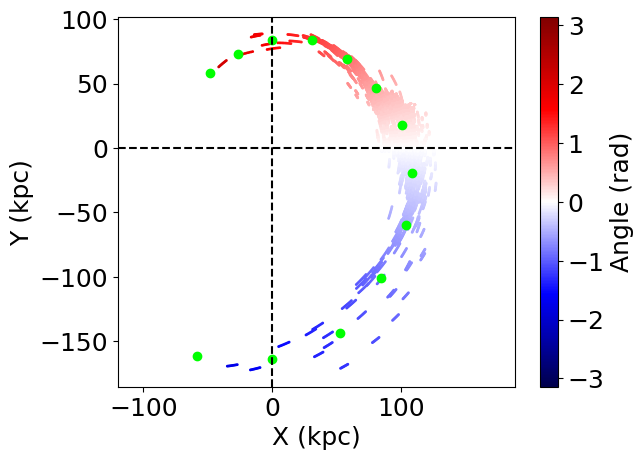

In [44]:
plt.scatter(xv_stream[:, 0], xv_stream[:, 1], c=theta_stream, s=1, cmap='seismic', vmin=-np.pi, vmax=np.pi)
plt.colorbar(label='Angle (rad)')
plt.scatter(r_bin*np.cos(theta_bin), r_bin*np.sin(theta_bin), c='lime')
plt.axvline(0, color='k', linestyle='--')
plt.axhline(0, color='k', linestyle='--')
plt.xlabel('X (kpc)')
plt.ylabel('Y (kpc)')
plt.axis('equal');

## (3) Binned method

In [59]:
from integrants import integrate_satellite
from potentials import NFWHessian
from utils import get_rj_vj_R, create_ic_particle_spray, jax_unwrap

import jax
import jax.numpy as jnp

backward_trajectory = integrate_satellite(x0, y0, z0, vx0, vy0, vz0, logM, Rs, q, dirx, diry, dirz, -time, n_steps)

forward_trajectory  = integrate_satellite(*backward_trajectory[-1, :], logM, Rs, q, dirx, diry, dirz, time*alpha, n_steps)

theta_sat_forward = jnp.arctan2(forward_trajectory[:, 1], forward_trajectory[:, 0])
theta_sat_forward = jnp.where(theta_sat_forward < 0, theta_sat_forward + 2 * jnp.pi, theta_sat_forward)
theta_sat_forward = jax_unwrap(theta_sat_forward)

hessians  = jax.vmap(NFWHessian, in_axes=(0, 0, 0, None, None, None, None, None, None)) \
                    (forward_trajectory[:, 0], forward_trajectory[:, 1], forward_trajectory[:, 2], logM, Rs, q, dirx, diry, dirz)
rj, vj, R = get_rj_vj_R(hessians, forward_trajectory, 10 ** logm)
ic_particle_spray = create_ic_particle_spray(forward_trajectory, rj, vj, R, 0, 111, n_particles, n_steps)

r_threshold = 2.0*jnp.max(rj)

index = jnp.repeat(jnp.arange(0, n_steps, 1), n_particles // n_steps)

dt = time*alpha / n_steps

In [284]:
from constants import KPC_TO_KM, GYR_TO_S
from potentials import NFWAcceleration, PlummerAcceleration
from utils import unwrap_step
@jax.jit
def leapfrog_individual_step(count, theta0, state, dt, logM, Rs, q, dirx, diry, dirz, logm, rs, xp, yp, zp, vxp, vyp, vzp):
    """
    Leapfrog integration step for both satellite and stream motion for NFW and Plummer potentials.
    """
    x, y, z, vx, vy, vz = state

    # Update Satellite Position
    axp, ayp, azp = NFWAcceleration(xp, yp, zp, logM, Rs, q, dirx, diry, dirz)

    vxp_half = vxp + 0.5 * dt * axp * KPC_TO_KM**-1
    vyp_half = vyp + 0.5 * dt * ayp * KPC_TO_KM**-1
    vzp_half = vzp + 0.5 * dt * azp * KPC_TO_KM**-1

    xp_new = xp + dt * vxp_half * GYR_TO_S * KPC_TO_KM**-1
    yp_new = yp + dt * vyp_half * GYR_TO_S * KPC_TO_KM**-1
    zp_new = zp + dt * vzp_half * GYR_TO_S * KPC_TO_KM**-1

    axp_new, ayp_new, azp_new = NFWAcceleration(xp_new, yp_new, zp_new, logM, Rs, q, dirx, diry, dirz)

    vxp_new = vxp_half + 0.5 * dt * axp_new * KPC_TO_KM**-1
    vyp_new = vyp_half + 0.5 * dt * ayp_new * KPC_TO_KM**-1
    vzp_new = vzp_half + 0.5 * dt * azp_new * KPC_TO_KM**-1

    # Update Stream Position
    ax, ay, az = NFWAcceleration(x, y, z, logM, Rs, q, dirx, diry, dirz) +  \
                    PlummerAcceleration(x, y, z, logm, rs, x_origin=xp, y_origin=yp, z_origin=zp) # km2 / s / Gyr / kpc

    vx_half = vx + 0.5 * dt * ax * KPC_TO_KM**-1 # km / s
    vy_half = vy + 0.5 * dt * ay * KPC_TO_KM**-1
    vz_half = vz + 0.5 * dt * az * KPC_TO_KM**-1

    x_new = x + dt * vx_half * GYR_TO_S * KPC_TO_KM**-1 # kpc
    y_new = y + dt * vy_half * GYR_TO_S * KPC_TO_KM**-1
    z_new = z + dt * vz_half * GYR_TO_S * KPC_TO_KM**-1

    ax_new, ay_new, az_new = NFWAcceleration(x_new, y_new, z_new, logM, Rs, q, dirx, diry, dirz) +  \
                                PlummerAcceleration(x_new, y_new, z_new, logm, rs, x_origin=xp_new, y_origin=yp_new, z_origin=zp_new) # km2 / s / Gyr / kpc

    vx_new = vx_half + 0.5 * dt * ax_new * KPC_TO_KM**-1 # km / s
    vy_new = vy_half + 0.5 * dt * ay_new * KPC_TO_KM**-1
    vz_new = vz_half + 0.5 * dt * az_new * KPC_TO_KM**-1

    theta = jnp.arctan2(y_new, x_new)
    theta = jax.lax.cond(theta < 0, lambda x: x + 2 * jnp.pi, lambda x: x, theta)
    theta = unwrap_step(theta, theta0)

    r_dist_here = jnp.sqrt( (x_new - xp_new)**2 + 
                            (y_new - yp_new)**2 + 
                            (z_new - zp_new)**2 )

    mask  = jax.lax.cond( (r_dist_here > r_threshold) & (count == 0), lambda: 1., lambda: jnp.nan)

    vt_here = jnp.sqrt( (vx_new - vxp_new)**2 + 
                        (vy_new - vyp_new)**2 + 
                        (vz_new - vzp_new)**2 )

    return theta, jnp.array([x_new, y_new, z_new, vx_new, vy_new, vz_new]), mask, vt_here

In [303]:
from tqdm import tqdm

@jax.jit
def masked_leapfrog(count_j, theta0_j, xv_j, idx_j, current_i, fwd_i_args):
    def do_step(_):
        return leapfrog_individual_step(count_j, theta0_j, xv_j, dt, logM, Rs, q, dirx, diry, dirz, logm, rs, *fwd_i_args)

    def skip_step(_):
        return theta0_j, xv_j, jnp.nan, jnp.nan

    return jax.lax.cond( (idx_j <= current_i) & (~jnp.isnan(count_j)), do_step, skip_step, operand=None)

In [ ]:
from utils import unwrap_stream_from_unwrapped_orbit, find_percentile_arg

xv_stream = ic_particle_spray.copy()
theta_stream = jnp.arctan2(xv_stream[:, 1], xv_stream[:, 0])
theta_stream = jnp.where(theta_stream < 0, theta_stream + 2 * jnp.pi, theta_stream)
count_stream = jnp.zeros(n_particles)

num_bin = 5

for i in tqdm(range(n_steps), leave=True):
    theta_stream, xv_stream, mask, vt = jax.vmap(masked_leapfrog, in_axes=(0, 0, 0, 0, None, None))(count_stream, theta_stream, xv_stream, index, i, forward_trajectory[i])
    wrong_bool_mask = jnp.isnan(mask)
    bool_mask = ~wrong_bool_mask
    arg_remove = wrong_bool_mask * 1.0 + bool_mask * jnp.nan

    nb_out = jnp.nansum(mask)
    if nb_out <= num_bin:
        count_stream += bool_mask

    else:
        gap = 1/(num_bin + 1) 

        arg_keep = jax.vmap(find_percentile_arg, in_axes=(0, None, None, None))(jnp.arange(num_bin), vt, mask, gap)
        arg_remove   = arg_remove.at[arg_keep].set(1.)
        count_stream = count_stream.at[arg_keep].set(nb_out / num_bin)
    
        theta_stream *= arg_remove
        xv_stream    *= arg_remove[:, None]
        count_stream *= arg_remove

count_stream = jnp.clip(count_stream, 1) # Set all still bound particles to 1
theta_stream = unwrap_stream_from_unwrapped_orbit(theta_sat_forward, theta_stream)


100%|██████████| 500/500 [00:02<00:00, 185.10it/s]


In [350]:
@jax.jit
def find_percentile_arg(nb, vt, mask, gap):
    arg_keep = jnp.nanargmin(jnp.abs(vt*mask - jnp.nanpercentile(vt*mask, 100 * gap * (nb + 1))))
    return arg_keep


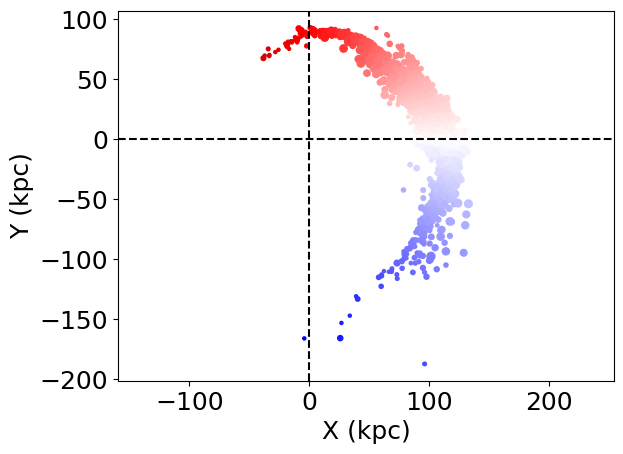

In [361]:
plt.scatter(xv_stream[:, 0], xv_stream[:, 1], s=5*jnp.clip(count_stream, 1), c=theta_stream, cmap='seismic', vmin=-np.pi, vmax=np.pi)
plt.axvline(0, color='k', linestyle='--')
plt.axhline(0, color='k', linestyle='--')
plt.xlabel('X (kpc)')
plt.ylabel('Y (kpc)')
plt.axis('equal');


In [4]:
from integrants import leapfrog_combined_step
from tqdm import tqdm
from utils import unwrap_step

In [5]:
@jax.jit
def leapfrog_individual_step(theta0, state, dt, logM, Rs, q, dirx, diry, dirz, logm, rs):
    """
    JAX-friendly wrapper around a leapfrog step that handles NaN states via jax.lax.cond.
    Always returns (theta, state).
    """

    def nan_branch(args):
        theta0, state = args
        # Keep theta continuous by leaving it at theta0 (or use jnp.nan if you prefer).
        return theta0, state

    def ok_branch(args):
        theta0, state = args
        state = leapfrog_combined_step(
            state, dt, logM, Rs, q, dirx, diry, dirz, logm, rs
        )
        theta = jnp.arctan2(state[1], state[0])
        theta = jax.lax.cond(theta < 0.0,
                                lambda x: x + 2.0 * jnp.pi,
                                lambda x: x,
                                theta)
        theta = unwrap_step(theta, theta0)
        return theta, jnp.stack(state)

    pred = jnp.any(jnp.isnan(state))
    return jax.lax.cond(pred, nan_branch, ok_branch, operand=(theta0, state))


In [36]:
r_threshold = 2.0*jnp.max(rj)

dt = time/n_steps
state0 = jnp.concatenate([ic_particle_spray, jnp.repeat(forward_trajectory, n_particles//n_steps, axis=0)], axis=1)
theta = jnp.arctan2(state0[:, 1], state0[:, 0])
theta = jnp.where(theta < 0, theta + 2 * jnp.pi, theta)

nb_bined = []
state = jnp.zeros_like(state0) * jnp.nan
state = state.at[:n_particles//n_steps].set(state0[:n_particles//n_steps])
count = jnp.zeros(state.shape[0])

thetaf = theta_sat_forward[-1]
for i in tqdm(range(n_steps), leave=True):

    theta, state = jax.vmap(leapfrog_individual_step, in_axes=(0, 0, None, None, None, None, None, None, None, None, None)) \
                        (theta, state, dt, logM, Rs, q, dirx, diry, dirz, logm, rs)

    state_here = state[:(n_particles//n_steps)*(i+1)]
    count_here = count[:(n_particles//n_steps)*(i+1)]

    r_here = jnp.sqrt( (state_here[:, 0] - state_here[:, 6])**2 + 
                        (state_here[:, 1] - state_here[:, 7])**2 + 
                        (state_here[:, 2] - state_here[:, 8])**2)

    arg_bin = jnp.where( (r_here > r_threshold) & (count_here == 0))[0]

    state_next = state0[(n_particles//n_steps)*(i+1):(n_particles//n_steps)*(i+2)]
    state      = state.at[:(n_particles//n_steps)*(i+2)].set(jnp.concatenate([state_here, state_next]))

    if arg_bin.size == 1:
        count = count.at[arg_bin[0]].set(1)
    elif arg_bin.size > 1:
        state_binned = state_here[arg_bin]
        theta_binned = theta[arg_bin]

        vt = jnp.sqrt( (state_binned[:, 3] - state_binned[:, 9])**2 + 
                        (state_binned[:, 4] - state_binned[:, 10])**2 )

        arg_median = jnp.argsort(vt)[len(vt)//2]
        arg_other  = jnp.delete(arg_bin, arg_median)

        state = state.at[arg_bin[arg_median]].set(state_binned[arg_median])
        state = state.at[arg_bin[arg_other]].set(jnp.nan)

        theta = theta.at[arg_bin[arg_median]].set(theta_binned[arg_median])# - thetaf + theta_count * 2 * jnp.pi + centered_at_0)
        theta = theta.at[arg_bin[arg_other]].set(jnp.nan)

        count = count.at[arg_bin[arg_median]].set(arg_bin.size)
        count = count.at[arg_bin[arg_other]].set(jnp.nan)

100%|██████████| 500/500 [05:24<00:00,  1.54it/s]


In [37]:
# === Process angles as a function of Progenitor ===
# Count how many complete 2pi rotations have been accumulated (integer division).
theta_count = jnp.floor_divide(theta_sat_forward, 2 * jnp.pi)

final_theta_stream = (
    theta #jnp.sum(theta_stream * diagonal_matrix, axis=1)
    - theta_sat_forward[-1]
    + jnp.repeat(theta_count,  n_particles// n_steps) * 2 * jnp.pi
    )

algin_reference = theta_sat_forward[-1]- theta_count[-1]*(2*jnp.pi) # Make sure the angle of reference is at theta=0

final_theta_stream += (1 - jnp.sign(algin_reference - jnp.pi))/2 * algin_reference + \
                        (1 + jnp.sign(algin_reference - jnp.pi))/2 * (algin_reference - 2 * jnp.pi)


In [39]:
count

Array([nan, nan, 36., ...,  0.,  0.,  0.], dtype=float64)

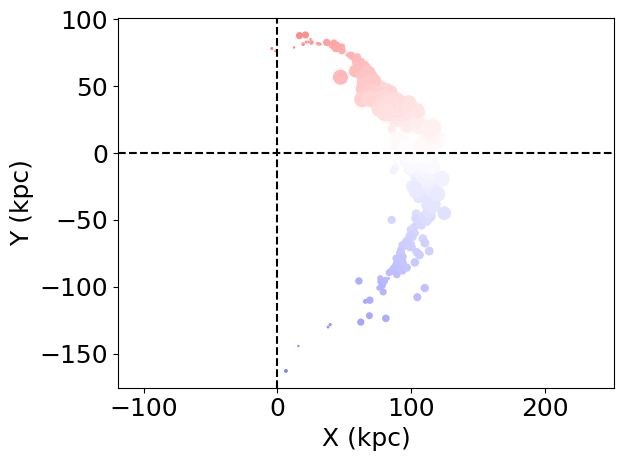

In [42]:
plt.scatter(state[:, 0], state[:, 1], c=final_theta_stream, cmap='seismic', vmin=-2*np.pi, vmax=2*np.pi, s=count/10)
plt.axvline(0, color='k', linestyle='--')
plt.axhline(0, color='k', linestyle='--')
plt.xlabel('X (kpc)')
plt.ylabel('Y (kpc)')
plt.axis('equal');

In [27]:
# @jax.jit
def get_track(theta_stream, x_stream, y_stream, weight, n_bins=36):
    # Step 1: Create bin edges and assign particles to bins
    r_stream = jnp.sqrt(x_stream**2 + y_stream**2)
    bin_edges   = jnp.linspace(-2 * jnp.pi, 2 * jnp.pi, n_bins + 1)
    theta_bin   = (bin_edges[:-1] + bin_edges[1:]) / 2
    bin_indices = jnp.digitize(theta_stream, bin_edges, right=True)

    # Step 2: Per-bin median computation
    def per_bin_median(bin_idx, bin_ids, r, w):
        mask     = bin_ids == bin_idx
        
        r_in_bin = jnp.where(mask, r, jnp.nan)
        w_in_bin = jnp.where(mask, w, jnp.nan)

        count    = jnp.sum(w_in_bin)

        weight_average = jnp.nansum(r_in_bin * w_in_bin) / count
        weight_std = jnp.sqrt(jnp.nansum(w_in_bin * (r_in_bin - weight_average)**2) / count)

        return count, weight_average, weight_std

    # Step 3: Vectorize
    all_bins = jnp.arange(1, n_bins + 1)
    count, r_bin, w_bin = jax.vmap(per_bin_median, in_axes=(0, None, None, None))(all_bins, bin_indices, r_stream, weight)

    return count, theta_bin, r_bin, w_bin

In [33]:
from utils import get_track

In [34]:
count_bin, theta_bin, r_bin, w_bin = get_track(final_theta_stream, state[:, 0], state[:, 1])#, count)

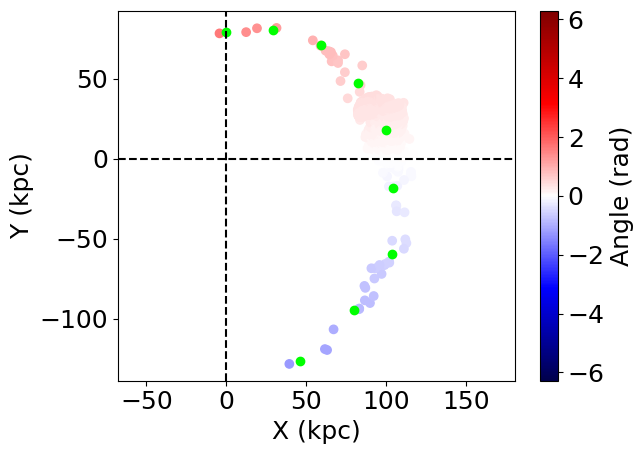

In [35]:
plt.scatter(state[:, 0], state[:, 1], c=final_theta_stream, cmap='seismic', vmin=-2*np.pi, vmax=2*np.pi)#, s=count)
plt.colorbar(label='Angle (rad)')
plt.scatter(r_bin*np.cos(theta_bin), r_bin*np.sin(theta_bin), c='lime')
plt.axvline(0, color='k', linestyle='--')
plt.axhline(0, color='k', linestyle='--')
plt.xlabel('X (kpc)')
plt.ylabel('Y (kpc)')
plt.axis('equal');

## (4) 2nd Degree method